In [30]:
import pandas as pd
import cvxpy as cp
import mosek
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200
import random
from scipy.integrate import cumtrapz

# Model

## Assumptions

1. flat surface,
2. pre-timed signals,
3. vehicle platoon with previous knowledge of the signal timings,
4. vehicle enter the corridor with 0 velocity,
5. constant air density and neglect wind pressure,
6. 

In [2]:
# powertrain constant to define

## Shared across platforms

m = 1611+82             # average vehicle mass + driver [kg]
rho = 1.225             # air density [kg/m^3]
Cd = 0.23               # drag coefficient
Aref = 2.22             # average vehicle frontal area [m^2]
g = 9.81                # gravity constant [m/s^2]
Crr = 0.01              # rolling resistance coefficient
Cv = 0.3                # kinetic friction coefficient
r = 0.334               # wheel radius [m] (235/45R18 tire)

## ICE only (Honda Civic 2012 5AT)
f_ice = 0.375           # idle fuel consumption [ml/s]
P_max = 104.398         # max engine power [kw]
P_min = 0               # min engine power [kw]
wp_max = 6500           # engine angular speed at max power [rpm]
wt_max = 4300           # engine angular speed at max torque [rpm]
gear = [2.666, 1.534, 1.022, 0.721, 0.525, 4.44] # gear ratio
cor_v = [0, 7.5, 11.4, 16, 22] # corresponding velocity for each gear(ex: gear 1 ratio = 2.666,cor_v = 0~7.5) [m/s]

## EV only
# f_ev =                # idle energy consumption[kW]
capacity_kWh = 54       # [kWh]
Voc = 360               # [V]
Pmax_kW = 211           # [kW]
Tmax_Nm = 375           # [Nm]
Tmax_rpm = 4000         # [rpm] max motor speed at max torque
gear_ratio = 9          # motor to driven axle gear ratio
max_speed = 16000       # [rpm] maximum motor speed
dt_eff = 0.85           # drivetrain efficiency
Rcirc = 0.05            # [Ohms]

In [24]:
# constraint constants to define

pos_final = 2000        # corridor horizon [m]
N = 380                 # time horizon [sec]
vel_lower = 0           # velocity lower bound [m/s]
vel_upper = 17.5        # velocity upper bound [m/s]
acc_abs = 1.5           # accel upper bound [m/s^2]
jerk_abs = 1            # jerk (derivative of acceleration) upper bound [m/s^3]
lin_drag = 10           # linearize drag about this speed

# Optimization Formulation

## 1. Optimization of one vehicle trajectory through pre-timed signalized intersections

x(t) = [s(t), v(t)], states: position and velocity \\
u(t) = [a(t)], control param: vehicle acceleration 

###**EV Powertrain**

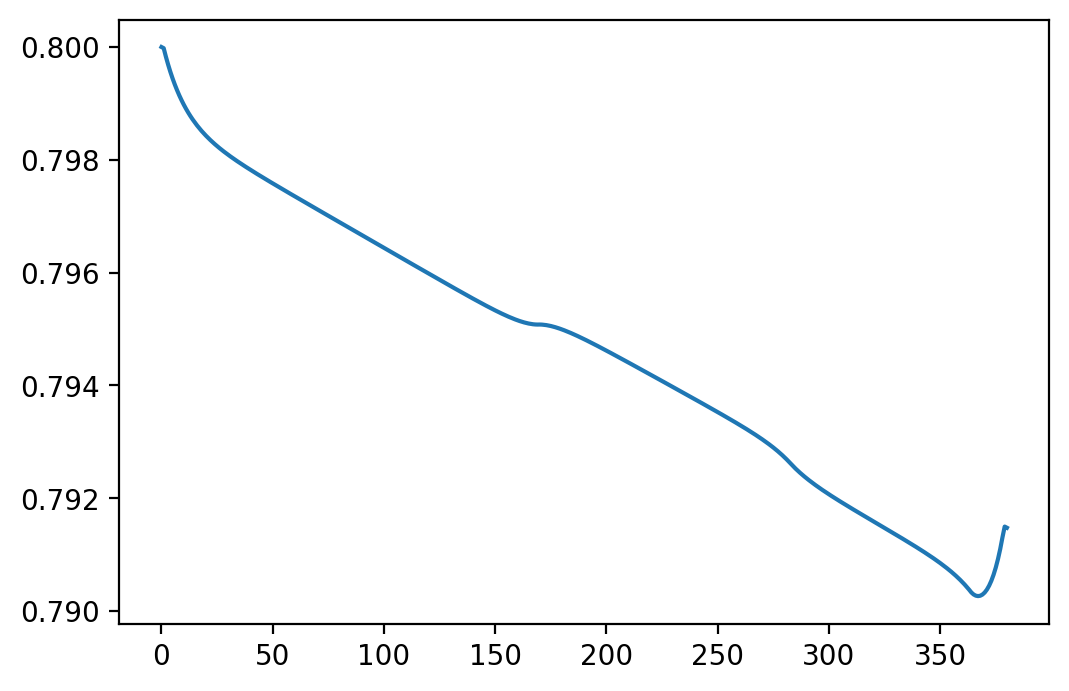

In [37]:
t = np.arange(N+1)

plt.plot(t, SOC.value)

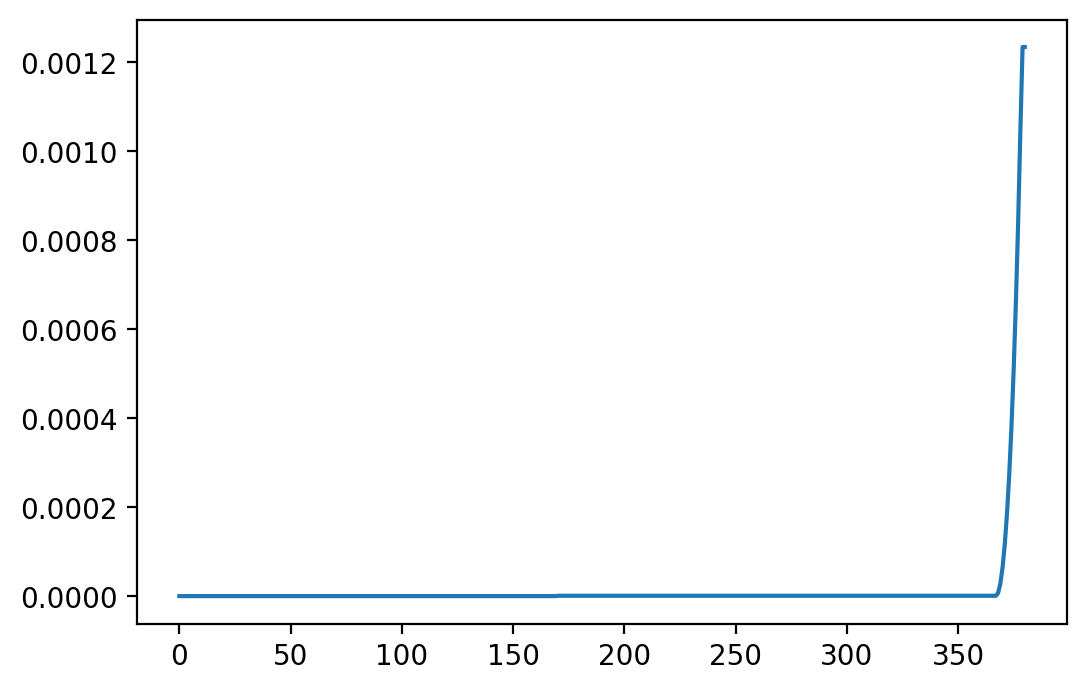

In [40]:
plt.plot(t, E_regen/(capacity_kWh*1000))

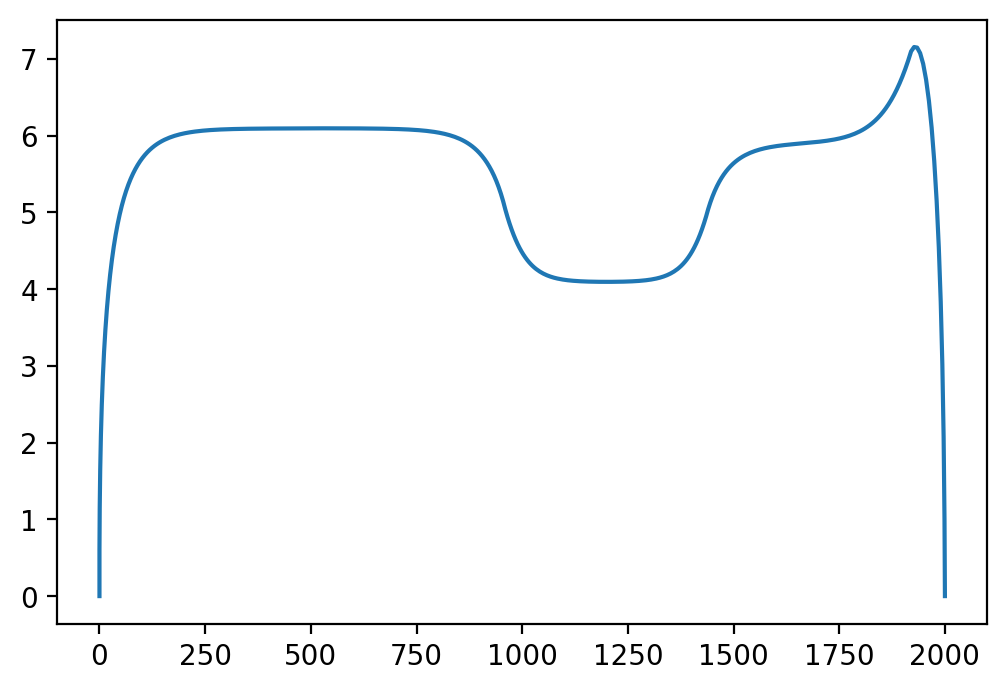

In [38]:
plt.plot(x1.value, x2.value)

In [ ]:
plt.plot(x1.value, x2.value)

In [34]:
# Assumptions:

# Solve with CVXPY

# Define optimization vars
N = 380 # minimum time is N~=pos_final/10*0.9
dt = 1
M = 1e5
x1 = cp.Variable(N+1) # Position
x2 = cp.Variable(N+1) # Velocity
T = cp.Variable(N) # Powertrain torque
Fdrag = cp.Variable(N) # Vehicle drag
E = cp.Variable(N+1) # Battery energy
Pmot = cp.Variable(N) # Battery power
Vcirc = cp.Variable(N) # Circuit voltage
I = cp.Variable(N) # Motor current
SOC = cp.Variable(N+1) # Battery SOC

# Define objective function
objective = cp.Minimize( E[0]-E[N] ); title = 'Minimum Energy' # Minimum energy
# objective = cp.Minimize(-x1@np.ones(N+1) + (E[0]-E[N])); title = 'Minimum Time' # Minimum time - Lower N until solver fails for guaranteed minimum time

# Define constraints
constraints = [ ]
# pos_init = 0 m
constraints += [ x1[0] == 0 ]
# pos_final = 1000 m
constraints += [ x1[N] == pos_final ]
# vel_init = 0 m/s
constraints += [ x2[0] == 0 ]
# vel_final = 0 m/s
constraints += [ x2[N] == 0 ]
# # acc_init = 0 m/s^2
constraints += [ x2[1] == x2[0] ]
# # acc_final = 0 m/s^2
constraints += [ x2[N] == x2[N-1] ]
# Traffic light constraints
# Define a traffic light as [initial time, final time, position]

tls = []
redlight = 30 # redlight duration [sec]
greenlight = 50 # greenlight duration [sec]
block = 240 # length of one block [m]
for intersection in np.arange(0, pos_final, block):
    for start in np.arange(10, N*dt, redlight + greenlight):
        tls.append([start, start + redlight, intersection]) # + random.randint(-5, 5)

tls_bools = {}
tls_on = True # Control whether or not traffic lights are used
# The for loop below will automatically create constraints for all traffic lights
for i in range(len(tls)):
    # Ensure that traffic light fits into optimization horizon
    if int(tls[i][0]/dt) <= N and tls_on:            
        dict_index = "tl{0}".format(i)
        tls_bools[dict_index] = cp.Variable(1, boolean=True)
        # Clip end of traffic light if it goes past optimization horizon
        t_initial = int(tls[i][0]/dt)
        if int(tls[i][1]/dt) > N:
            t_final = N
        else:
            t_final = int(tls[i][1]/dt)
        position = tls[i][2]
        constraints += [ x1[t_final]   - position <=  M*tls_bools[dict_index] ]
        constraints += [ x1[t_initial] - position >= -M*(1-tls_bools[dict_index]) ]

for k in range(0,N):
    # vel_lower >= 0 m/s
    constraints += [ x2[k+1] >= vel_lower ]
    # vel_lower <= 15 m/s (~55 km/hr)
    constraints += [ x2[k+1] <= vel_upper ]
    # acc_lower >= -3 m/s^2
    constraints += [ (x2[k+1] - x2[k])/dt >= -acc_abs ]
    # acc_upper <= 3 m/s^2
    constraints += [ (x2[k+1] - x2[k])/dt <= acc_abs ]
    constraints += [ x1[k+1] == x1[k] + x2[k]*dt ]
    constraints += [ x2[k+1] == x2[k] + ( (T[k])/m/r*gear_ratio*dt_eff - Fdrag[k]/m)*dt ]
    constraints += [ Fdrag[k] >= 0.5*rho*Cd*Aref*x2[k]**2 + Cv*x2[k] + Crr*m*g ]
    constraints += [ E[k+1] == E[k] - Voc*Vcirc[k]/Rcirc*dt/3600 ]
    constraints += [ x2[k]*60/(2*np.pi*r)*gear_ratio <= 10000 ]
    constraints += [ T[k] <= Tmax_Nm/(max_speed-Tmax_rpm)*max_speed + (Tmax_Nm/-(max_speed-Tmax_rpm))*x2[k]*60/(2*np.pi*r)*gear_ratio ]
    constraints += [ T[k] >= - Tmax_Nm/(max_speed-Tmax_rpm)*max_speed - (Tmax_Nm/-(max_speed-Tmax_rpm))*x2[k]*60/(2*np.pi*r)*gear_ratio ]

# SOC
constraints += [ SOC[0] == 0.8 ]
constraints += [ SOC == E/capacity_kWh/1000]
constraints += [ SOC <= 0.8 ]
constraints += [ SOC >= 0.2 ]
# Power
constraints += [ Pmot <= Vcirc/Rcirc*Voc - (Vcirc)**2/Rcirc ] # Relaxed SOC constraint --> Becomes tight to minimize energy loss
constraints += [ T <= Tmax_Nm ]
constraints += [ T >= -Tmax_Nm ]
constraints += [ T == Pmot/(Pmax_kW*1000)*Tmax_Nm ]
# Voc
constraints += [ Vcirc/Rcirc <= (Pmax_kW*1000)/Voc ] # Current limit

for k in range(1, N):
    # Minimize jerk (derivative of acceleration)
    constraints += [ (x2[k+1] - 2*x2[k] + x2[k-1])/dt**2 <= jerk_abs ]
    constraints += [ (x2[k+1] - 2*x2[k] + x2[k-1])/dt**2 >= -jerk_abs ]

In [35]:
prob = cp.Problem(objective, constraints)
prob.solve(verbose=True, solver='MOSEK')
print(prob.status)



Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 10358           
  Cones                  : 760             
  Scalar variables       : 6129            
  Matrix variables       : 0               
  Integer variables      : 45              

Optimizer started.
Mixed integer optimizer started.
Threads used: 12
Presolve started.
Presolve terminated. Time = 0.06
Presolved problem: 3805 variables, 4156 constraints, 10950 non-zeros
Presolved problem: 0 general integer, 19 binary, 3786 continuous
Clique table size: 0
BRANCHES RELAXS   ACT_NDS  DEPTH    BEST_INT_OBJ         BEST_RELAX_OBJ       REL_GAP(%)  TIME  
0        2        1        0        NA                   4.5935576731e+02     NA          0.3   
0        2        1        0        4.6041742040e+02     4.5935576731e+02     0.23        0.8   
0        2        1        0        4.6041541425e+02 

===== Minimum Energy =====
Min SOC = 0.79026
Final SOC = 0.79147
Recovered SOC = 0.0012338
Estimated Range = 145.76 miles
Time of Travel = 379 seconds
Max Torque = 52.06 Nm
Max Power = 29.29 kW
Max Motor Speed = 1841 RPM
Max Vel = 7.155 m/s
Max Acc = 0.6062 m/s^2
Max Jerk = 1.0 m/s^3


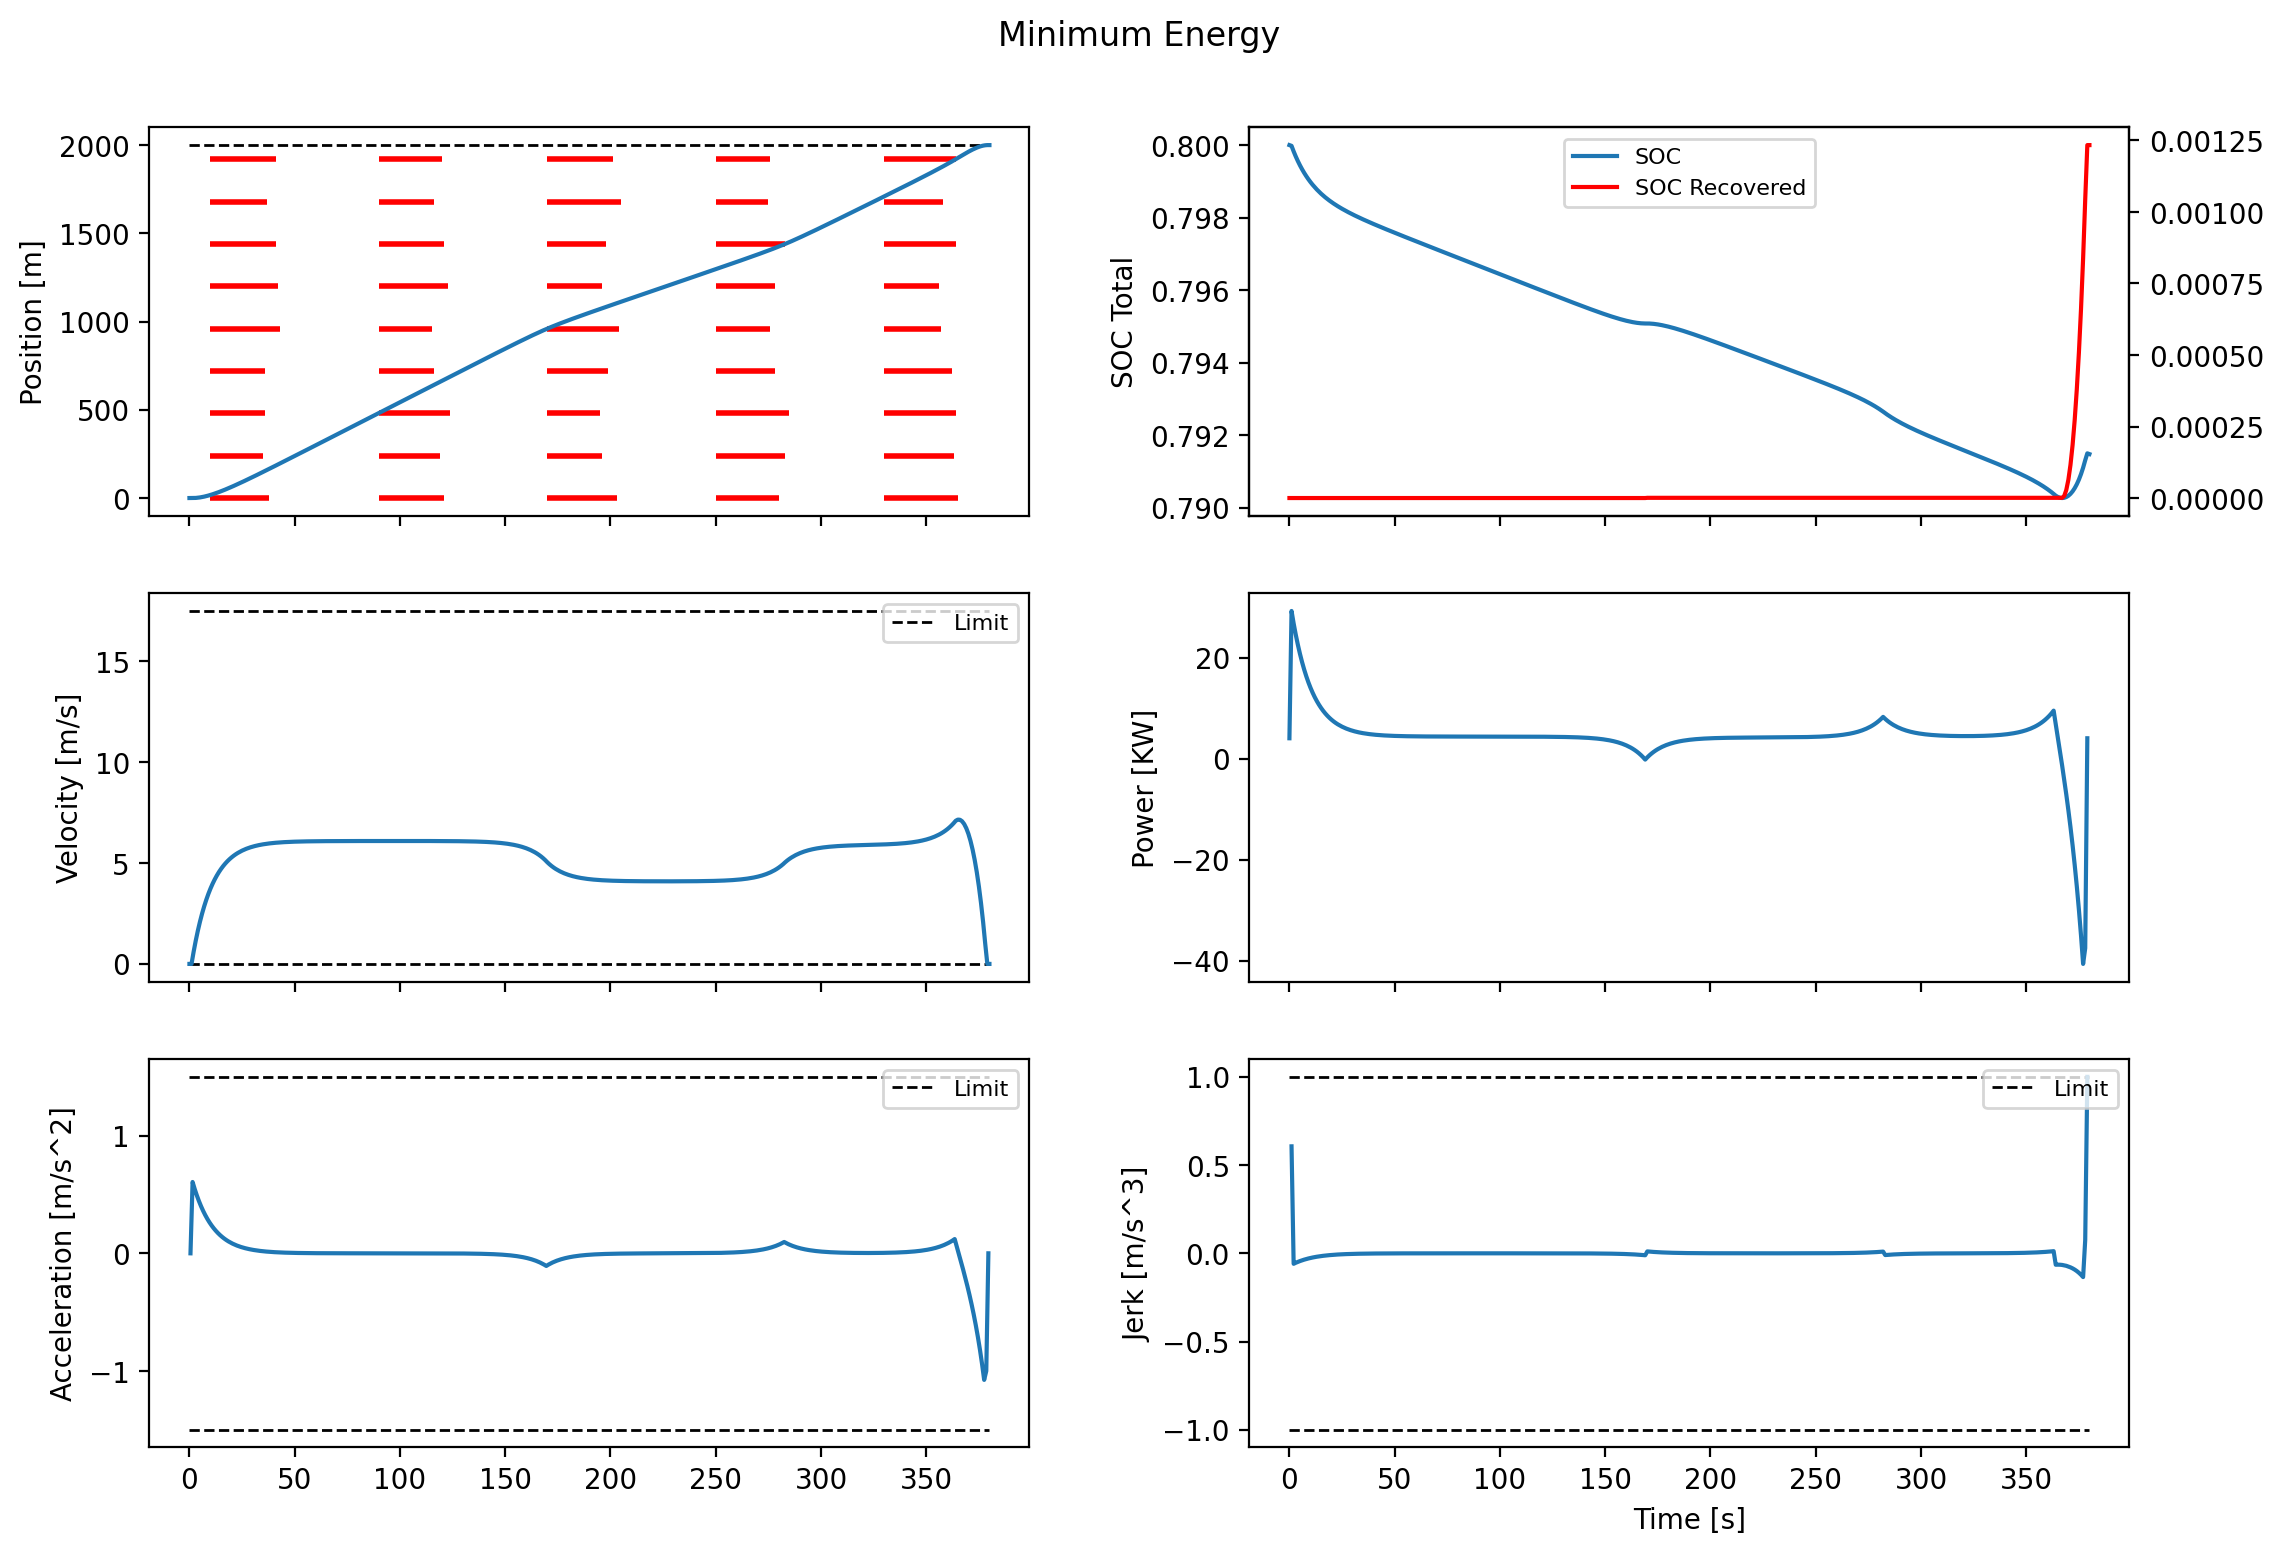

In [36]:
# Calculate recovered energy
E_regen = np.zeros(N+1)
for i in range(1,len(E_regen)):
    if Vcirc.value[i-1] < 0:
        E_regen[i] = E_regen[i-1] - Voc*Vcirc.value[i-1]/Rcirc*dt/3600
    else:
        E_regen[i] = E_regen[i-1]

print(f"======{'='*len(title)}======")
print(f"===== {title} =====")
print(f"======{'='*len(title)}======")
print(f"Min SOC = {np.min(SOC.value):.5}")
print(f"Final SOC = {(SOC.value[-1]):.5}")
print(f"Recovered SOC = {E_regen[-1]/(capacity_kWh*1000):.5}")
print(f"Estimated Range = {1/(SOC.value[0]-SOC.value[-1])*pos_final/1609.34:.5} miles")
print(f"Time of Travel = {np.where(x1.value>=pos_final-0.00001)[0][0]*dt:.0f} seconds")
print(f"Max Torque = {np.max(T.value):.2f} Nm")
print(f"Max Power = {np.max(Pmot.value)/1000:.2f} kW")
print(f"Max Motor Speed = {np.max(x2.value*60/(2*np.pi*r)*gear_ratio):.0f} RPM")
print(f"Max Vel = {np.max((x2.value)):.4} m/s")
print(f"Max Acc = {np.max((x2.value[1:]-x2.value[:-1])/dt):.4} m/s^2")
print(f"Max Jerk = {np.max((x2.value[2:]-2*x2.value[1:-1]+x2.value[:-2])/dt**2):.4} m/s^3")

time = np.arange(0, (N+1)*dt, dt)
fig, axs = plt.subplots(3,2, figsize=(12,8), sharex=True)
axs = axs.flatten()
legend_font = 8
fig.suptitle(title)
# Plot order
plt_pos = 0
plt_vel = 2
plt_acc = 4
plt_jerk = 5
plt_power = 3
plt_soc = 1
axs[plt_pos].plot(time, x1.value)
axs[plt_pos].set_ylabel('Position [m]')
for i in range(len(tls)):
    # Ensure that traffic light fits into optimization horizon
    if int(tls[i][plt_pos]/dt) <= N:
        axs[plt_pos].hlines(y=tls[i][2], xmin=tls[i][0], xmax=tls[i][1], linewidth=2, color='r')

axs[plt_pos].hlines(y=pos_final, xmin=0, xmax=int(N*dt), color='k', linestyle='--', linewidth=1, label='Destination')
axs[plt_acc].plot((time[1:]+time[:-1])/2, (x2.value[1:]-x2.value[:-1])/dt)
axs[plt_acc].hlines(y=-acc_abs, xmin=0, xmax=int(N*dt), color='k', linestyle='--', linewidth=1, label='Limit')
axs[plt_acc].hlines(y=acc_abs, xmin=0, xmax=int(N*dt), color='k', linestyle='--', linewidth=1)
axs[plt_acc].legend(loc='upper right', fontsize=legend_font)
axs[plt_acc].set_ylabel('Acceleration [m/s^2]')
axs[plt_vel].plot(time, x2.value)
axs[plt_vel].hlines(y=vel_lower, xmin=0, xmax=int(N*dt), color='k', linestyle='--', linewidth=1, label='Limit')
axs[plt_vel].hlines(y=vel_upper, xmin=0, xmax=int(N*dt), color='k', linestyle='--', linewidth=1)
axs[plt_vel].legend(loc='upper right', fontsize=legend_font)
axs[plt_vel].set_ylabel('Velocity [m/s]')
axs[plt_jerk].plot((time[2:]+time[:-2])/2, (x2.value[2:]-2*x2.value[1:-1]+x2.value[:-2])/dt**2)
axs[plt_jerk].hlines(y=-jerk_abs, xmin=0, xmax=int(N*dt), color='k', linestyle='--', linewidth=1, label='Limit')
axs[plt_jerk].hlines(y=jerk_abs, xmin=0, xmax=int(N*dt), color='k', linestyle='--', linewidth=1)
axs[plt_jerk].legend(loc='upper right', fontsize=legend_font)
axs[plt_jerk].set_ylabel('Jerk [m/s^3]')
axs[plt_power].plot(time[:-1], Pmot.value/1000)
axs[plt_power].set_ylabel('Power [KW]')
axs[plt_soc].plot(time, SOC.value, label='SOC')
axs[plt_soc].set_ylabel('SOC Total')
axs[plt_soc].yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.3f}'))
axstwinsoc = axs[plt_soc].twinx()
axstwinsoc.plot(time, E_regen/(capacity_kWh*1000), 'r', label='SOC Recovered')
h1, l1 = axs[plt_soc].get_legend_handles_labels()
h2, l2 = axstwinsoc.get_legend_handles_labels()
axs[plt_soc].legend(h1+h2, l1+l2, loc='upper center', fontsize=legend_font)
axs[-1].set_xlabel('Time [s]')
plt.tight_layout()
plt.subplots_adjust(left  = 0.0875, right = 0.9125, bottom = 0.0875, top = 0.9125, wspace = 0.25, hspace = 0.2)
plt.show()

### **ICV Powertrain**

#### **Assumptions**
The parameters used in the model is from 2012 Honda Civic 1.8 5AT. 

Engine Model based on 'Ni and Henclewood (2008)'   [Pe = sum(ci * we^i)]

Gear Model based on 'Wong, Theory of Ground Vehicles., 3rd ed', and 'Ni and Henclewood (2008)'

Torque converter model is ignored for now

In the gear model, assume the gear is changing based on the velocity, and acheive the 5th gear when the velocity is greater or equal to 80 km/hr (~22 m/sec). In addition, assume that the max velocity at each gear multiply with overall reduction ratio (ie, gear ratio multiply final gear ratio) is the same.

##### **ex**
For the 5th gear, the min velocity is 22 m/sec, gear ratio is 0.525, final gear ratio is 4.44, 

22 x 0.525 x 4.44 = 51.282

For 4th gear, the gear ratio is 0.721, the max speed at this gear is: v = 51.282/0.721/4.44 = 16 [m/sec] 

**Some issues for gear box constraints need to be fixed**

In [ ]:
# Define optimization vars
N = 380 # minimum time is N~=pos_final/10*0.9
dt = 1
M = 1e5
x1 = cp.Variable(N+1) # Position
x2 = cp.Variable(N+1) # Velocity
T = cp.Variable(N) # Powertrain torque
Fdrag = cp.Variable(N) # Vehicle drag
Pe = cp.Variable(N) # Power of engine
we = cp.Variable(N) # Angular speed of engine

bl_1 = cp.Variable(1, boolean = True)
bl_2 = cp.Variable(1, boolean = True)
bl_3 = cp.Variable(1, boolean = True)
bl_4 = cp.Variable(1, boolean = True)
bl_5 = cp.Variable(1, boolean = True)

# Define objective function
objective = cp.Minimize( sum(Pe) ); title = 'Minimum Energy' # Minimum energy
# objective = cp.Minimize(-x1@np.ones(N+1) + (E[0]-E[N])); title = 'Minimum Time' 
# Minimum time - Lower N until solver fails for guaranteed minimum time

# Define constraints
constraints = [ ]
# pos_init = 0 m
constraints += [ x1[0] == 0 ]
# pos_final = 1000 m
constraints += [ x1[N] == 2000 ]
# vel_init = 0 m/s
constraints += [ x2[0] == 0 ]
# vel_final = 0 m/s
constraints += [ x2[N] == 0 ]
# # acc_init = 0 m/s^2
constraints += [ x2[1] == x2[0] ]
# # acc_final = 0 m/s^2
constraints += [ x2[N] == x2[N-1] ]

# Traffic light constraints
# Define a traffic light as [initial time, final time, position]
tls = []
redlight = 30 # redlight duration [sec]
greenlight = 50 # greenlight duration [sec]
block = 240 # length of one block [m]
for intersection in np.arange(0, pos_final, block):
    for start in np.arange(10, N*dt, redlight + greenlight):
        tls.append([start, start + redlight, intersection])

tls_bools = {}
tls_on = True # Control whether or not traffic lights are used

# The for loop below will automatically create constraints for all traffic lights
for i in range(len(tls)):
    # Ensure that traffic light fits into optimization horizon
    if int(tls[i][0]/dt) <= N and tls_on:            
        dict_index = "tl{0}".format(i)
        tls_bools[dict_index] = cp.Variable(1, boolean=True)
        # Clip end of traffic light if it goes past optimization horizon
        t_initial = int(tls[i][0]/dt)
        if int(tls[i][1]/dt) > N:
            t_final = N
        else:
            t_final = int(tls[i][1]/dt)
        position = tls[i][2]
        constraints += [ x1[t_final]   - position <=  M*tls_bools[dict_index] ]
        constraints += [ x1[t_initial] - position >= -M*(1-tls_bools[dict_index]) ]

for k in range(0,N):
    # vel_lower >= 0 m/s
    constraints += [ x2[k+1] >= vel_lower ]
    # vel_lower <= 15 m/s (~55 km/hr)
    constraints += [ x2[k+1] <= vel_upper ]
    # acc_lower >= -3 m/s^2
    constraints += [ (x2[k+1] - x2[k])/dt >= -acc_abs ]
    # acc_upper <= 3 m/s^2
    constraints += [ (x2[k+1] - x2[k])/dt <= acc_abs ]
    constraints += [ x1[k+1] == x1[k] + x2[k]*dt ]
    constraints += [ x2[k+1] == x2[k] + ( (T[k])/m/r*gear_ratio*dt_eff - Fdrag[k]/m)*dt ]
    constraints += [ Fdrag[k] >= 0.5*rho*Cd*Aref*x2[k]**2 + Cv*x2[k] + Crr*m*g ]
    
    # Engine Model
    constraints += [ Pe[k] >= P_max/wp_max * we[k] + P_max/wp_max**2 * we[k]**2 - P_max/wp_max**3 * 1500**3]
#     constraints += [ Pe[k] >= P_max/(2*wp_max**2)*(3*wp_max-wt_max)*we[k] - P_max/(2*wp_max**2*(wp_max-wt_max))]
#     constraints += [ Pe[k] >= P_max/wp_max * we[k] + P_max/wp_max**2 * we[k]**2 - P_max/wp_max**3 * we[k]**3]

    # Gear Model
    constraints += [ x2[k] <= cor_v[1] + bl_1 * M]
    constraints += [ x2[k] >= cor_v[0] - bl_1 * M]
    constraints += [ x2[k] - we[k]*r*(2*np.pi/60)/(gear[0]*gear[5]) == 0]
#    constraints += [ x2[k] - we[k]*r*(2*np.pi/60)/(gear[0]*gear[5]) >= bl_1 * M]

#     constraints += [ x2[k] <= cor_v[2] + bl_2 * M]
#     constraints += [ x2[k] >= cor_v[1] - bl_2 * M]
#     constraints += [ x2[k] - we[k]*r*(2*np.pi/60)/(gear[1]*gear[5]) >= bl_2 * M]
#     constraints += [ x2[k] - we[k]*r*(2*np.pi/60)/(gear[1]*gear[5]) >= (1-bl_2) * M]
    
#     constraints += [ x2[k] <= cor_v[3] + bl_3 * M]
#     constraints += [ x2[k] >= cor_v[2] - bl_3 * M]
#     constraints += [ x2[k] <= we[k]*r*(2*np.pi/60)/(gear[2]*gear[5]) + bl_3 * M]
#     constraints += [ x2[k] >= we[k]*r*(2*np.pi/60)/(gear[2]*gear[5]) - (1-bl_3) * M]
    
for k in range(1, N):
    # Minimize jerk (derivative of acceleration)
    constraints += [ (x2[k+1] - 2*x2[k] + x2[k-1])/dt**2 <= jerk_abs ]
    constraints += [ (x2[k+1] - 2*x2[k] + x2[k-1])/dt**2 >= -jerk_abs ]
    
constraints += [ Pe <= P_max]
constraints += [ Pe >= P_min]
constraints += [ we <= wp_max]
constraints += [ we >= 0]


In [ ]:
prob = cp.Problem(objective, constraints)
prob.solve(verbose=True, solver='MOSEK')
print(prob.status)



Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 8914            
  Cones                  : 760             
  Scalar variables       : 5408            
  Matrix variables       : 0               
  Integer variables      : 86              

Optimizer started.
Mixed integer optimizer started.
Threads used: 1
Presolve started.
Presolve terminated. Time = 0.05
Presolved problem: 3426 variables, 3061 constraints, 7626 non-zeros
Presolved problem: 0 general integer, 18 binary, 3408 continuous
Clique table size: 0
BRANCHES RELAXS   ACT_NDS  DEPTH    BEST_INT_OBJ         BEST_RELAX_OBJ       REL_GAP(%)  TIME  
0        2        1        0        NA                   1.3406469809e+04     NA          0.5   
0        2        1        0        1.3449729276e+04     1.3406469809e+04     0.32        1.2   
Cut generation started.
0        2        1        0   

Max Vel = 5.915 m/s


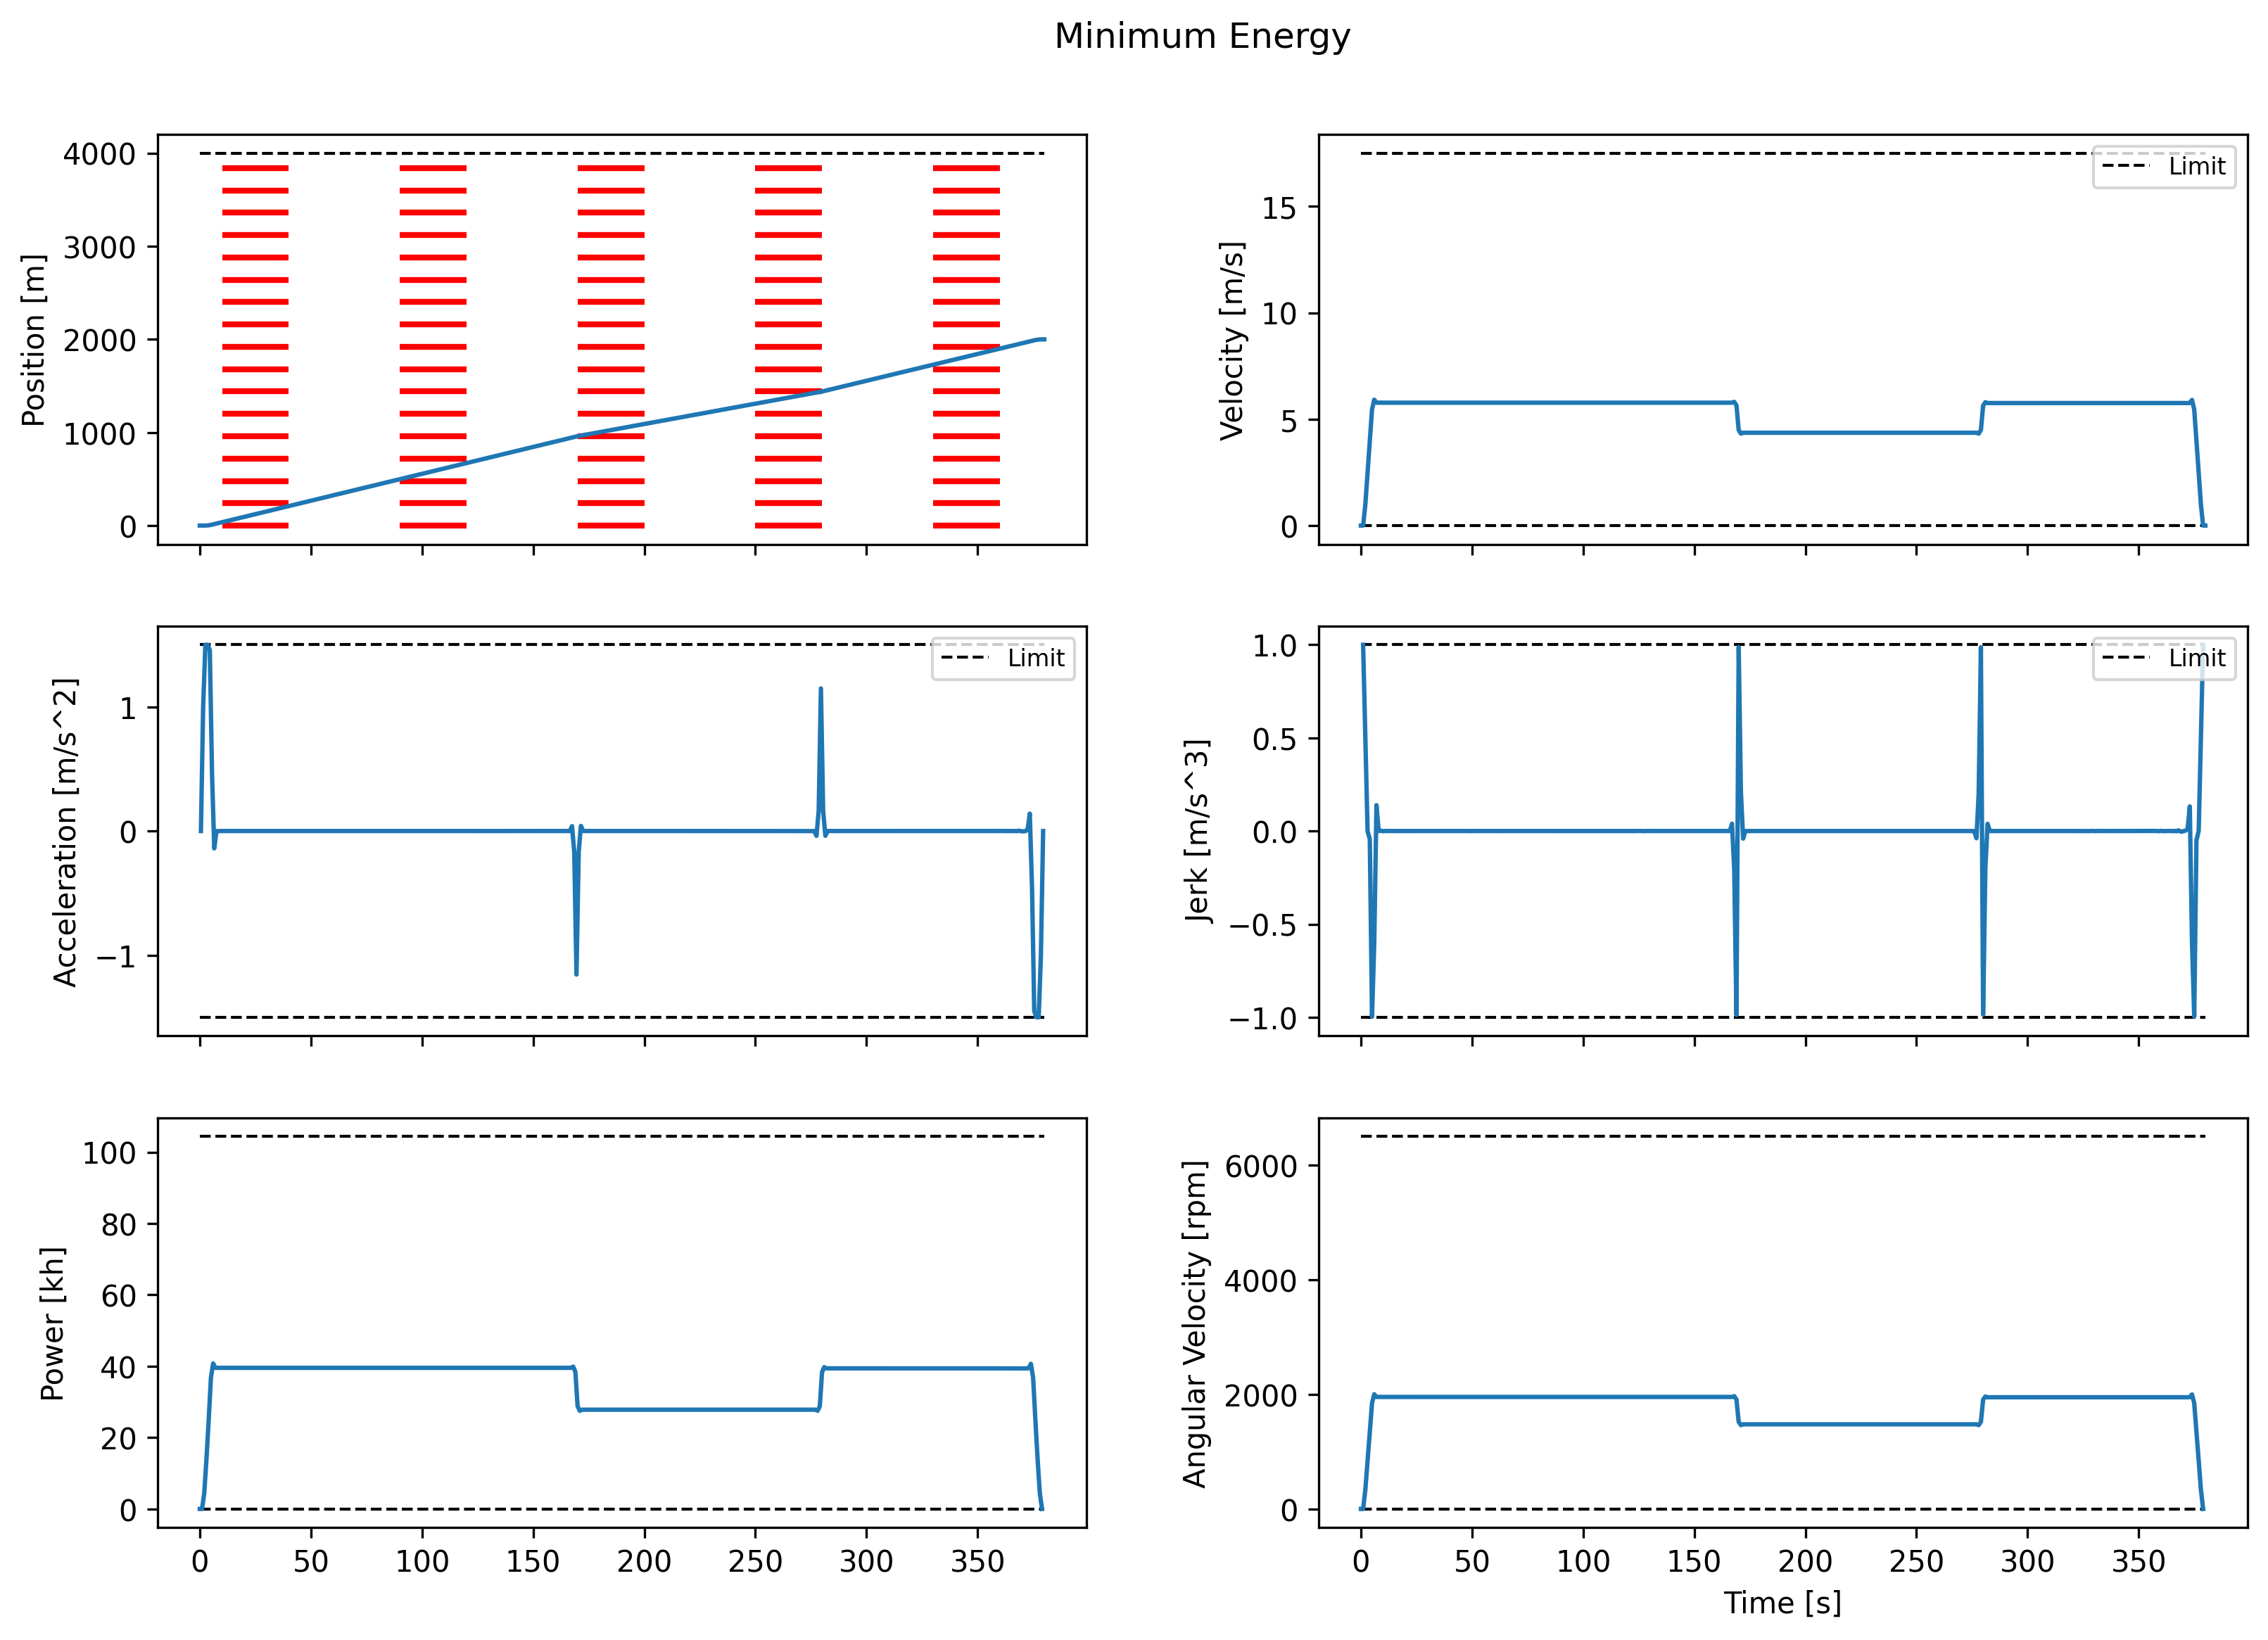

In [ ]:
# print(f"======{'='*len(title)}======")
# print(f"===== {title} =====")
# print(f"======{'='*len(title)}======")
# print(f"Min SOC = {np.min(SOC.value):.5}")
# print(f"Final SOC = {(SOC.value[-1]):.5}")
# print(f"Recovered SOC = {E_regen[-1]/(capacity_kWh*1000):.5}")
# print(f"Estimated Range = {1/(SOC.value[0]-SOC.value[-1])*pos_final/1609.34:.5} miles")
# print(f"Time of Travel = {np.where(x1.value>=pos_final-0.00001)[0][0]*dt:.0f} seconds")
# print(f"Max Torque = {np.max(T.value):.2f} Nm")
# print(f"Max Power = {np.max(Pmot.value)/1000:.2f} kW")
# print(f"Max Motor Speed = {np.max(x2.value*60/(2*np.pi*r)*gear_ratio):.0f} RPM")
print(f"Max Vel = {np.max((x2.value)):.4} m/s")
# print(f"Max Acc = {np.max((x2.value[1:]-x2.value[:-1])/dt):.4} m/s^2")
# print(f"Max Jerk = {np.max((x2.value[2:]-2*x2.value[1:-1]+x2.value[:-2])/dt**2):.4} m/s^3")

time = np.arange(0, (N+1)*dt, dt)
fig, axs = plt.subplots(3,2, figsize=(12,8), sharex=True)
axs = axs.flatten()
legend_font = 8
fig.suptitle(title)
# Plot order
plt_pos = 0
plt_vel = 1
plt_acc = 2
plt_jerk = 3
plt_power = 4
plt_ang = 5
axs[plt_pos].plot(time, x1.value)
axs[plt_pos].set_ylabel('Position [m]')
for i in range(len(tls)):
    # Ensure that traffic light fits into optimization horizon
    if int(tls[i][plt_pos]/dt) <= N:
        axs[plt_pos].hlines(y=tls[i][2], xmin=tls[i][0], xmax=tls[i][1], linewidth=2, color='r')

axs[plt_pos].hlines(y=pos_final, xmin=0, xmax=int(N*dt), color='k', linestyle='--', linewidth=1, label='Destination')
axs[plt_acc].plot((time[1:]+time[:-1])/2, (x2.value[1:]-x2.value[:-1])/dt)
axs[plt_acc].hlines(y=-acc_abs, xmin=0, xmax=int(N*dt), color='k', linestyle='--', linewidth=1, label='Limit')
axs[plt_acc].hlines(y=acc_abs, xmin=0, xmax=int(N*dt), color='k', linestyle='--', linewidth=1)
axs[plt_acc].legend(loc='upper right', fontsize=legend_font)
axs[plt_acc].set_ylabel('Acceleration [m/s^2]')
axs[plt_vel].plot(time, x2.value)
axs[plt_vel].hlines(y=vel_lower, xmin=0, xmax=int(N*dt), color='k', linestyle='--', linewidth=1, label='Limit')
axs[plt_vel].hlines(y=vel_upper, xmin=0, xmax=int(N*dt), color='k', linestyle='--', linewidth=1)
axs[plt_vel].legend(loc='upper right', fontsize=legend_font)
axs[plt_vel].set_ylabel('Velocity [m/s]')
axs[plt_jerk].plot((time[2:]+time[:-2])/2, (x2.value[2:]-2*x2.value[1:-1]+x2.value[:-2])/dt**2)
axs[plt_jerk].hlines(y=-jerk_abs, xmin=0, xmax=int(N*dt), color='k', linestyle='--', linewidth=1, label='Limit')
axs[plt_jerk].hlines(y=jerk_abs, xmin=0, xmax=int(N*dt), color='k', linestyle='--', linewidth=1)
axs[plt_jerk].legend(loc='upper right', fontsize=legend_font)
axs[plt_jerk].set_ylabel('Jerk [m/s^3]')
axs[plt_power].plot(time[:-1], Pe.value)
axs[plt_power].hlines(y=0, xmin=0, xmax=int(N*dt), color='k', linestyle='--', linewidth=1, label='Limit')
axs[plt_power].hlines(y=P_max, xmin=0, xmax=int(N*dt), color='k', linestyle='--', linewidth=1)
axs[plt_power].set_ylabel('Power [kh]')
axs[plt_ang].plot(time[:-1], we.value)
axs[plt_ang].hlines(y=0, xmin=0, xmax=int(N*dt), color='k', linestyle='--', linewidth=1, label='Limit')
axs[plt_ang].hlines(y=wp_max, xmin=0, xmax=int(N*dt), color='k', linestyle='--', linewidth=1)
axs[plt_ang].set_ylabel('Angular Velocity [rpm]')
axs[-1].set_xlabel('Time [s]')
plt.tight_layout()
plt.subplots_adjust(left  = 0.0875, right = 0.9125, bottom = 0.0875, top = 0.9125, wspace = 0.25, hspace = 0.2)
plt.show()

## 2. Platoon Optimization Formulation

### Assumptions for the Vehicle Platoon

1. one single lane, no merging and overtaking
2. fixed signal
3. when entering corridor, all CAV have same initial state, same spacing between, and same initial speed
4. straight line movements, no turning is considered

### Methods

- PTO (platoon-trajectory-optimization): trajectory copying the leading CAV with delay and min. gap defined 
- LACC



In [ ]:
N = 6             # Number of CAV in one platoon
tau = 0.1         # reaction time of each CAV [s]
l = d + v_0*tau   # initial space between two CAV [m]


NameError: ignored